# Kickstarter EDA
This is the beginning of an exploratory data analysis of the kickstarter dataset from webrobots.io.

Webrobots.io runs a monthly scrape of Kickstarter's website, and posts the results [here](https://webrobots.io/kickstarter-datasets/) <br><br>
The dataset I'm working with was scraped on 2/2019, and contains historical projects as well as active ones<br><br>
Kickstarter limits the number of results that it shows in a particular project category, so not all projects are shown here<br><br>

# Data Cleaning
Most of the data cleaning done so far has been around selecting interesting columns that I think will be useful for an analysis. 

The original dataset had over 30 columns, much of it was either duplicates, or urls for images used on the project pages

The remaining data cleaning work has been focused around pulling data out of JSON objects from the original dataset

The merging and cleaning scripts will be posted on Github later

In [1]:
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import numpy as np
import sklearn as skl
import datetime
import pdb

In [2]:
df = pd.read_csv('2019KickDataCleaned.csv', index_col = 0)

Check out the data to see if it was imported correctly. 

All of the columns that are time/date related are in epoch time, and I've decided to leave it that way for now since it makes it easier to do things like calculate elapsed times

In [3]:
df.head()

,backers_count,blurb,country,created_at,creator,currency,deadline,goal,id,launched_at,...,slug,spotlight,staff_pick,state,state_changed_at,urls,usd_pledged,subcats,fullcats,city
0,9,A comedy web series about the inherently funny...,US,1489891481,915430313,USD,1494132705,5000.0,1203770415,1491540705,...,the-start-up-0,False,False,failed,1494132705,https://www.kickstarter.com/projects/915430313...,508.000000,Comedy,film & video,"Austin, TX"
1,36,"Cabo y un Capitán, dos soldados villistas, tra...",MX,1508479978,1011928721,MXN,1512917074,65000.0,878861613,1509893074,...,los-muertos-de-columbus-the-dead-of-columbus,True,False,successful,1512917074,https://www.kickstarter.com/projects/101192872...,3397.485019,Shorts,film & video,"Mexico City, Mexico"
2,61,We're building the new home of Māori Theatre a...,NZ,1426499822,1902194044,NZD,1429596000,10000.0,917345297,1427147079,...,whare-no-name-the-new-home-of-maori-theatre,True,False,successful,1429596012,https://www.kickstarter.com/projects/190219404...,7834.340234,Theater,theater,"Auckland, NZ"
3,1730,Comic-book stories celebrate women who crack c...,US,1482813229,121124061,USD,1489666144,40000.0,1702164653,1487077744,...,femme-magnifique,True,True,successful,1489666144,https://www.kickstarter.com/projects/hificolou...,97447.000000,Anthologies,comics,"Scottsdale, AZ"
4,183,"A Victorian “gaslamp” lesbian romance, set in ...",US,1506228739,484654302,USD,1510473540,2000.0,1042930184,1507662001,...,miss-bullards-school-for-former-ladies,True,False,successful,1510473540,https://www.kickstarter.com/projects/484654302...,3911.000000,Video Games,games,"San Francisco, CA"


In [4]:
df.describe()

,backers_count,created_at,creator,deadline,goal,id,launched_at,state_changed_at,usd_pledged
count,208240.000000,2.082400e+05,2.082400e+05,2.082400e+05,2.082400e+05,2.082400e+05,2.082400e+05,2.082400e+05,2.082400e+05
mean,146.213273,1.454714e+09,1.074468e+09,1.461640e+09,4.909297e+04,1.072924e+09,1.458817e+09,1.461459e+09,1.300566e+04
std,876.014770,6.233873e+07,6.202857e+08,6.197563e+07,1.181872e+06,6.197091e+08,6.200823e+07,6.184290e+07,8.766031e+04
min,0.000000,1.240366e+09,3.000000e+00,1.242468e+09,1.000000e-02,8.624000e+03,1.240920e+09,1.242468e+09,0.000000e+00
25%,4.000000,1.412760e+09,5.371463e+08,1.420038e+09,1.500000e+03,5.347041e+08,1.416943e+09,1.419869e+09,1.060000e+02
50%,27.000000,1.456788e+09,1.073502e+09,1.463603e+09,5.000000e+03,1.074857e+09,1.460752e+09,1.463505e+09,1.544000e+03
75%,89.000000,1.509249e+09,1.612665e+09,1.516428e+09,1.500000e+04,1.608201e+09,1.513365e+09,1.516385e+09,6.614000e+03
max,105857.000000,1.550094e+09,2.147483e+09,1.555299e+09,1.000000e+08,2.147476e+09,1.550119e+09,1.550119e+09,8.596475e+06


# Data Skewed-ness

From a first look at the descriptive statistics on the dataset, the data seems to be heavily skewed.

The means and medians (50%) for "goal", and "usd_pledged", are off by an order of magnitude.

I know there's a lot of different categories of projects, and some of the skew is probably due to different funding goals for different categories of projects (ex. A video publishing project needs a lot less money than the first run of a new hardware device)

In [5]:
df.columns

Index(['backers_count', 'blurb', 'country', 'created_at', 'creator',
       'currency', 'deadline', 'goal', 'id', 'launched_at', 'name', 'slug',
       'spotlight', 'staff_pick', 'state', 'state_changed_at', 'urls',
       'usd_pledged', 'subcats', 'fullcats', 'city'],
      dtype='object')

In [6]:
#Filter out projects that are live, canceled, or suspended
fil = df[(df['state'] == 'successful')|(df['state'] =='failed')] 
sucMask = fil.state == 'successful'
suc = fil[sucMask]
fSuc = len(suc)/len(fil)
fSuc

0.6092480387117543

## Relative frequency of successful projects

I'm focusing my analysis on projects that have completed their funding campaigns, so I'm filtering out any projects that were canceled, suspended, or currently active

It seems around 60% of projects that finish their funding campaigns successfully reach their goals

<Figure size 43200x21600 with 0 Axes>

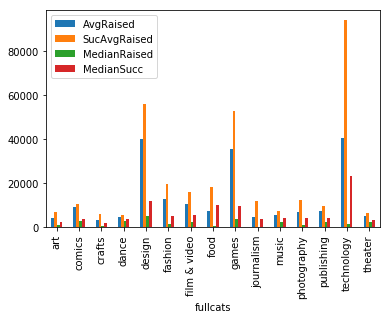

In [7]:
# Compare the money raised by succesfull projects against all projects in a certain category
money = pd.DataFrame()
grp = fil.groupby(['fullcats'])
sucGrp = suc.groupby(['fullcats'])
money['AvgRaised'] = grp.usd_pledged.agg(np.mean)
money['SucAvgRaised'] = sucGrp.usd_pledged.agg(np.mean)
money['MedianRaised'] = grp.usd_pledged.agg(np.median)
money['MedianSucc'] = sucGrp.usd_pledged.agg(np.median)
#money.reset_index(inplace = True)
plt.figure(figsize=(600,300))
money.plot(kind = 'bar')

# Comparing the Money Raised
The chart above compares average money pledged to projects in different categories against average raised in succesfully funded projects. It also gives a comparison of the medians for each category

As was seen in the descriptive statistics, there's a heavy skew here. Based on the median pledge totals, it seems like a lot of projects raise almost no money at all

<Figure size 43200x21600 with 0 Axes>

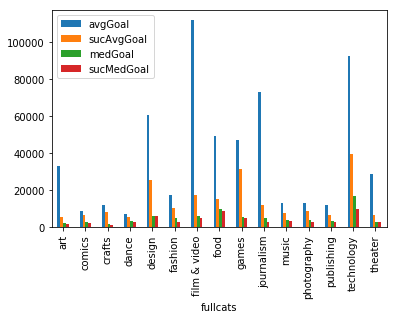

In [9]:
# Compare the funding goals for successful projects in each category vs. the funding goals of all projects
goal = pd.DataFrame()
goal['avgGoal'] = grp.goal.agg(np.mean)
goal['sucAvgGoal'] = sucGrp.goal.agg(np.mean)
goal['medGoal'] = grp.goal.agg(np.median)
goal['sucMedGoal'] = sucGrp.goal.agg(np.median)
plt.figure(figsize=(600,300))
goal.plot(kind = 'bar')

## Comparing pledge goals

The same skew shows up in the fundraising goals for each project, there seems to be a few projects that have very high funding goals.

What's interesting here is that most projects have significantly lower funding goals than the top projects. It's difficult to see, but it also seems there's a relatively small difference in the median funding goals between successful projects and all projects

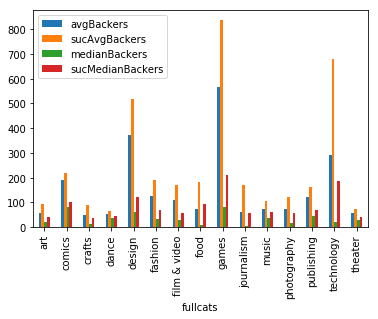

In [10]:
# Look at the number of backers for successful projects in each category vs. the backers for all projects
backers = pd.DataFrame()
backers['avgBackers'] = grp.backers_count.mean()
backers['sucAvgBackers'] = sucGrp.backers_count.mean()
backers['medianBackers'] = grp.backers_count.median()
backers['sucMedianBackers'] = sucGrp.backers_count.median()
#backers.reset_index(inplace = True)
backers.plot(kind = 'bar')

## Backers information

No surprises that succesfully funded projects have more backers than the general population

The average number of backers for each category seems to give more evidence to a few very popular projects skewing the average

Since this is just a count of total number of backers, and not the amounts they pledged, the top projects not only raise much larger amounts of money, but they also get a very large number of small donors as well

I need to compare average pledges across these projects

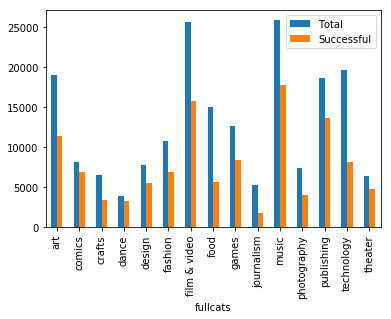

In [21]:
# Look at the number of successfully funded projects in each category vs. the total number of projects
counts = pd.DataFrame()
counts['Total'] = grp.size()
counts['Successful'] = sucGrp.size()
#counts.reset_index(inplace = True)
counts.plot(kind = 'bar')

## Funding success across categories

Not a lot of love for journalism projects on kickstarter, but users of the website seem to love comics, dance, and theater projects

In [20]:
#Filter the projects list down to projects that raised at least $100
moMoney = fil[fil['usd_pledged'] > 100]
moMoneySucc = moMoney[moMoney['state'] == 'successful' ]
ratio = len(moMoneySucc) / len(moMoney)
print(ratio)

0.7817180098767091


## Success rate of projects above a certain amount raised

Wow. The original success rate for all projects was around 60%.

For projects that raised a minimum of $100, that success rate shoots up to 80%

I need to compare that information against funding goals in each category, and compare this succsess rate in each category